In [6]:

import pandas as pd
import numpy as np
import torch
from typing import List, Tuple, Sequence
SEED=20

In [7]:
!curl -o ml-latest-small.zip http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
# backup location
#!curl -o ml-latest-small.zip http://www.dcs.gla.ac.uk/~craigm/recsysHM/ml-latest-small.zip
!unzip -o ml-latest-small.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  955k  100  955k    0     0   499k      0  0:00:01  0:00:01 --:--:--  499k
Archive:  ml-latest-small.zip
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [8]:
ratings_df = pd.read_csv("ml-latest-small/ratings.csv")
movies_df = pd.read_csv("ml-latest-small/movies.csv")

# we're going to treat userId as strings, and similarly as movies. This will prevent confusion later on.
ratings_df['userId'] =  "u" + ratings_df['userId'].astype(str)
ratings_df['movieId'] = "m" + ratings_df['movieId'].astype(str)
movies_df['movieId'] = "m" +  movies_df['movieId'].astype(str)

In [9]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,u1,m1,4.0,964982703
1,u1,m3,4.0,964981247
2,u1,m6,4.0,964982224
3,u1,m47,5.0,964983815
4,u1,m50,5.0,964982931


In [10]:
movies_df.head()

,movieId,title,genres
0,m1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,m2,Jumanji (1995),Adventure|Children|Fantasy
2,m3,Grumpier Old Men (1995),Comedy|Romance
3,m4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,m5,Father of the Bride Part II (1995),Comedy


#  User-based CF

In [11]:
r_df_matrix = ratings_df.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)
r_df_matrix

movieId,m1,m10,m100,m100044,m100068,m100083,m100106,m100159,m100163,m100194,m100226,m100277,m1003,m100302,m100304,m100306,m100326,m100383,m100390,m100397,m1004,m100487,m100498,m1005,m100507,m100527,m100553,m100556,m100579,m1006,m100611,m1007,m100714,m100737,m1008,m100810,m100843,m100882,m1009,m100906,...,m98836,m98908,m98961,m99,m990,m99005,m99007,m99030,m99087,m991,m99106,m99112,m99114,m99117,m99122,m99130,m99145,m99149,m99191,m993,m994,m99415,m99437,m99532,m99574,m996,m99636,m99638,m99721,m99728,m99750,m99764,m998,m99813,m99846,m99853,m999,m99910,m99917,m99992
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
u1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
u95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u96,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
r_df_matrix.index

Index(['u1', 'u10', 'u100', 'u101', 'u102', 'u103', 'u104', 'u105', 'u106',
       'u107',
       ...
       'u90', 'u91', 'u92', 'u93', 'u94', 'u95', 'u96', 'u97', 'u98', 'u99'],
      dtype='object', name='userId', length=610)

In [13]:
r_df_matrix.loc['u1']

movieId
m1         4.0
m10        0.0
m100       0.0
m100044    0.0
m100068    0.0
          ... 
m99853     0.0
m999       0.0
m99910     0.0
m99917     0.0
m99992     0.0
Name: u1, Length: 9724, dtype: float64

In [14]:
def cos_sim(a, b):
  from numpy.linalg import norm
  from numpy import dot
  return dot(a, b)/(norm(a)*norm(b))

print('Cosine similarity between userId=1 and itself is:')
print(cos_sim(r_df_matrix.loc['u1'].values, r_df_matrix.loc['u1'].values))

print('Cosine similarity between userId=1 and userId=607 is:')
print(cos_sim(r_df_matrix.loc['u1'].values, r_df_matrix.loc['u607'].values))

Cosine similarity between userId=1 and itself is:
1.0
Cosine similarity between userId=1 and userId=607 is:
0.2693892401115333


In [15]:
from scipy.stats import rankdata

def get_most_similar_users(userId : str, k : int = 10) -> Tuple[Sequence[str], Sequence[float]]:
  # Add your solution here
  sim_user=[]
  user_cos=[]
  for i in r_df_matrix.index:
    similarity=cos_sim(r_df_matrix.loc[userId].values,r_df_matrix.loc[i].values)#u(i) -> cos_sim[u(userId)]
    sim_user.append(i)
    user_cos.append(similarity)
  #store the values in the df
  df=pd.DataFrame(list(zip(sim_user,user_cos)),columns=['userId','cosine_similarity'])
  df=df.sort_values(by=['cosine_similarity'],ascending=False) #sorting
  
  #from index = 1 since index 0 is the user itself
  topk_userids = df.userId[1:k+1].tolist() # a list/numpy array of k userIds of top-k users
  topk_cosines = df.cosine_similarity[1:k+1].tolist() # a list/numpy array of k cosine similarity values
  return (topk_userids, topk_cosines)

print(get_most_similar_users(userId='u3', k=1))

# Add your solution here (cosine similarity > 0)


(['u313'], [0.07818732282993371])


##  Predict ratings via user-based CF.
 

In [16]:
def predict_rating(userId : str, movieId : str) -> float:
  # add your solution here
  #get the similar users, cosine_sim from the get_most_similar_users
  similar_user,cosine_sim = get_most_similar_users(userId,10)#k=10
  user_similarity_sum=0 
  predicted=0  #ypred
  for i in range(0,len(similar_user)): #for every user and its similar users
    if r_df_matrix.loc[similar_user[i],movieId]!=0: #if the similar user rated that item
      user_similarity_sum += cosine_sim[i] #denominator 
      predicted +=cosine_sim[i] * r_df_matrix.loc[similar_user[i],movieId] #if 2(user_sim)*3(rating)
  predicted = predicted/user_similarity_sum #total_predicted/total_user_similarities

  #predicted = "?" # predicted rating value
  return predicted

print("Predicted rating:", predict_rating(userId='u1', movieId='m1'))

print("Actual rating:", r_df_matrix.loc['u1']['m1'])

Predicted rating: 3.898822026597358
Actual rating: 4.0


##  Predict ratings via user-based CF with Mean-center normalisation.


In [17]:
def mean_rating(userId : str) -> float: #mean rating of the user 
  # add your solution here
  movies_rated_by_user=len(np.array(r_df_matrix.loc[userId]).nonzero()[0]) #return non zero elements in the array
  mean_rating = np.sum(r_df_matrix.loc[userId]/movies_rated_by_user) # mean-centering value
  return mean_rating

print("Mean rating of user u5:", mean_rating('u5') )

def predict_rating_MC(userId : str, movieId : str) -> float:
  # add your solution here 
  #same predict_rating function 
  #with users_mean_rating bias considered

  similar_user,cosine_sim = get_most_similar_users(userId,10)#k=10
  user_similarity_sum=0 
  predicted=0  #ypred
  users_mean_rating=mean_rating(userId) #users mean raiting = user bias
  for i in range(0,len(similar_user)): #for every user and its similar users
    if r_df_matrix.loc[similar_user[i],movieId]!=0: #if the similar user rated that item
      user_similarity_sum += cosine_sim[i] #denominator 
      #user mean -> user bias
      users_mean = mean_rating(similar_user[i])
      predicted +=cosine_sim[i] * ( r_df_matrix.loc[similar_user[i],movieId] - users_mean) #if 2(user_sim)*3(rating)
  predicted = users_mean_rating+ predicted/user_similarity_sum #total_predicted/total_user_similarities
 # predicted = "?" # predicted rating value with mean-centering
  return predicted

print("Predicted rating:", predict_rating_MC('u1', 'm1'))
print("Actual rating:", r_df_matrix.loc['u1']['m1'])

Mean rating of user u5: 3.6363636363636367
Predicted rating: 4.769198526598025
Actual rating: 4.0


#Explicit Matrix Factorisation using Spotlight

In [18]:
!pip install git+https://github.com/cmacdonald/spotlight.git@master#egg=spotlight

  Cloning https://github.com/cmacdonald/spotlight.git (to revision master) to /tmp/pip-install-v6lm2xzl/spotlight_6e617cdd32fb4040986a0014f4b11836
  Running command git clone -q https://github.com/cmacdonald/spotlight.git /tmp/pip-install-v6lm2xzl/spotlight_6e617cdd32fb4040986a0014f4b11836
  Created wheel for spotlight: filename=spotlight-0.1.6-py3-none-any.whl size=34106 sha256=f07ca8b0c45d4703a42fbbe96e33c194e35bcff3d9d997c7ac87b44b043198cc
  Stored in directory: /tmp/pip-ephem-wheel-cache-vzff7le_/wheels/1c/2a/31/d187173520bc800643df4e3d1f97dee21d2133ba41085704ed
Successfully built spotlight


In [19]:
from collections import defaultdict
from itertools import count

#create userId -> uid mapping dictionary. the next assigned value is the current size.
uid_map = defaultdict(count().__next__)
#ditto for movieId -> iid
iid_map = defaultdict(count().__next__)

#uids is an array of integers corresponding to the userId for every row in ratings_df
#uid_map does the assignment of new uid values, or reusing the uid value assigned for
#each userId
uids = np.array([uid_map[uid] for uid in ratings_df["userId"].values ], dtype=np.int32)
#similar for iids
iids = np.array([iid_map[iid] for iid in ratings_df["movieId"].values ], dtype=np.int32)

#freeze uid_map and iid_map so no more mappings are created
uid_map.default_factory = None
iid_map.default_factory = None

#reverse them, so we can go from iid (int) to itemId (str)
uid_rev_map = {v: k for k, v in uid_map.items()}
iid_rev_map = {v: k for k, v in iid_map.items()}
num_items = len(iid_map)
num_users = len(uid_map)

print("%d users %d item" % (num_users, num_items))

ratings = ratings_df["rating"].values.astype(np.float32)
timestamps = ratings_df["timestamp"].values.astype(np.int32)

print("userId %s got uid %d" % ("u556", uid_map["u556"]))
print("movieId %s got iid %d" % ("m54001", iid_map["m54001"]))

610 users 9724 item
userId u556 got uid 555
movieId m54001 got iid 2518


## On towards MF

In [20]:
from spotlight.interactions import Interactions
from spotlight.cross_validation import random_train_test_split

dataset = Interactions(user_ids=uids,
                                  item_ids=iids,
                                  ratings=ratings,
                                  timestamps=timestamps)

#lets initialise the seed, so that its repeatable and reproducible 
train, test = random_train_test_split(dataset, random_state=np.random.RandomState(SEED))

In [21]:
print(train)
print(test)

<Interactions dataset (610 users x 9724 items x 80668 interactions)>
<Interactions dataset (610 users x 9724 items x 20168 interactions)>


Here, you can see that following the collaborative filtering task model (see Lecture 6), all users, and all items, are present in both training and test sets.

In [22]:
print(train.item_ids.shape)
print(train.user_ids.shape)
print(train.ratings.shape)

(80668,)
(80668,)
(80668,)


In [23]:
print("uid %d gave iid %d a rating of %d" % (train.user_ids[0], train.item_ids[0],train.ratings[0]))

uid 56 gave iid 1491 a rating of 2


In [24]:
# map userId to the internal uid value
userId = "u556"
uid = uid_map.get(userId)

# see which ratings are for this user. Use this to filter the item and ratings arrays. 
# here we are filtering a numpy array based on an array of True/False values. Its just
# like filtering a Pandas data frame.
print(train.item_ids[train.user_ids == uid])
print(train.ratings[train.user_ids == uid])

[6082 6087  457 1925 7951 1132  764 5989  753 1342 1893 3076 3258 1182
 1938 1894 4796  926  770 8659 2059  917 1077  912  779  322 1307 3087
 2518  774]
[4.  3.5 5.  5.  4.  4.  4.  4.  4.5 4.  4.  4.5 4.  4.  4.5 3.5 4.  4.
 4.  4.  4.  3.5 5.  2.5 4.  5.  4.  4.  4.  4. ]


In [25]:
from spotlight.factorization.explicit import ExplicitFactorizationModel
import time  

emodel = ExplicitFactorizationModel(n_iter=10,
                                    embedding_dim=32, #this is Spotlight default
                                    use_cuda=False,
                                    random_state=np.random.RandomState(SEED) # ensure results are repeatable
)
current = time.time()

emodel.fit(train, verbose=True)

end = time.time()
diff = end - current
print("Training took %d seconds "% (diff))

Epoch 0: loss 4.3081090674747395
Epoch 1: loss 0.8099101063194154
Epoch 2: loss 0.5096786571077153
Epoch 3: loss 0.3636633798102789
Epoch 4: loss 0.2919712789073775
Epoch 5: loss 0.25697739233699024
Epoch 6: loss 0.23643478482395788
Epoch 7: loss 0.22271784451566165
Epoch 8: loss 0.2139979781983774
Epoch 9: loss 0.20728877597028697
Training took 13 seconds 


In [26]:
userId = "u556"

# convert the string to the internal integer
uid = uid_map.get(userId)
print("One test item_id for userId %s (uid %d) is " % (userId, uid))

# pick one rating that the user made
testItemId = test.item_ids[test.user_ids == uid][0] 
print("Test movieId is %s iid %d " % (iid_rev_map.get(testItemId), testItemId ) )


#here 0 is a dummy item, which Spotlight needs for some reason...
#we discard its prediction using [1]
predicted = emodel.predict( np.array([uid]), item_ids=np.array([0, testItemId]) )[1]

#what was the actual score of the user for that movie?
#we can get the appropriate row from the ratings dataframe, then extract that value
actual = ratings_df[(ratings_df.movieId==iid_rev_map.get(testItemId)) & (ratings_df.userId==userId)]["rating"].values[0]


def getMovieTitle(iid):
  return movies_df[movies_df['movieId'] == iid_rev_map.get(iid)]["title"].values[0]

print("Predicted rating for '%s' was %f, actual rating %0.1f, error was %f" % (getMovieTitle(testItemId), predicted, actual, abs(predicted-actual) )) 


One test item_id for userId u556 (uid 555) is 
Test movieId is m74530 iid 8141 
Predicted rating for 'Percy Jackson & the Olympians: The Lightning Thief (2010)' was 2.574092, actual rating 3.5, error was 0.925908


In [27]:
allpreds = emodel.predict( np.array([uid]) )

print(allpreds)
print(allpreds.size)

#we can recover the original rating for our test item 
print(allpreds[testItemId])

# lets just check we got the correct prediction
print(allpreds[testItemId] - actual < 0.1)

[3.9689248  4.3499784  4.5101566  ... 0.87423515 2.7873065  0.9850692 ]
9724
2.5740924
True


## Latent Factors aka Embeddings

In [28]:
#the embedding of an item is a PyTorch tensor of size 32
#a PyTorch tensor can be thought of having similar semantics as an numpy array.
print(emodel._net.item_embeddings.weight[0].shape)
emodel._net.item_embeddings.weight[0]


torch.Size([32])


tensor([ 0.1223, -0.3951, -0.3488,  0.0474,  0.7867, -0.0242,  0.2448,  0.7672,
        -0.1924, -0.0686, -0.1228,  0.6061, -0.1798, -0.3621,  0.7326,  0.2025,
        -0.1660, -0.3077, -0.3590, -0.3852,  0.2369, -0.6257,  0.7370,  0.8468,
         0.0755, -0.4360, -0.1154, -0.2451, -0.0357, -0.0060,  0.1001,  0.2164],
       grad_fn=<SelectBackward>)

In [29]:
# uid=555 for u556
# testItemId is our item of interest

dotprod = (emodel._net.user_embeddings.weight[uid] * emodel._net.item_embeddings.weight[testItemId]).sum(0)
user_bias = emodel._net.user_biases(torch.tensor([uid]))
item_bias = emodel._net.item_biases(torch.tensor([testItemId], dtype=torch.long))

print(getMovieTitle(testItemId))

dotprod + user_bias + item_bias

Percy Jackson & the Olympians: The Lightning Thief (2010)


tensor([[2.5741]], grad_fn=<AddBackward0>)

##  Examining Latent Factors



In [30]:
import torch.nn as nn
nn.functional.cosine_similarity(
     torch.tensor([1.0,0]),
     torch.tensor([0,1.0],), dim=0)

tensor(0.)

In [31]:
targetIId=iid_map["m81834"]
a=emodel._net.item_embeddings.weight[targetIId]
a #to get the embedding weights of the target movie

tensor([ 0.7272, -0.3795,  0.1719, -0.8317,  0.7841, -0.0126,  0.0426,  0.7044,
        -0.4959,  0.4894, -0.1102,  0.4305, -0.6199, -0.0366,  0.1803,  0.2544,
        -0.2255,  0.3797, -0.2439, -0.1055,  0.4677, -0.0541,  0.0852,  0.9091,
        -0.3590, -0.9817, -0.1562,  0.3706, -0.2103, -0.0146,  0.5229, -0.1545],
       grad_fn=<SelectBackward>)

In [32]:
import torch.nn as nn

def mostsimilar(targetIId : int, model):
  highest=0
  highestCos=0
  
  #you may assume that model._num_items provides the total number of items
  latent_embedding= emodel._net.item_embeddings.weight[targetIId] #latent embeddings of the targetIID
  for i in range(emodel._num_items):
    if i!=targetIId:
      latent_i = emodel._net.item_embeddings.weight[i] #embeddings of i
      cosine_sim= nn.functional.cosine_similarity(latent_embedding,latent_i,dim=0) #cos_sim(a,b)
      if cosine_sim>highestCos:
        highestCos=cosine_sim
        highest = i #update till we get the most similar item

  ##SOLUTION FROM HERE

  #####################

  print(train.num_items)
  print("targetMovieId = %s '%s' (iid %d)" % (iid_rev_map.get(targetIId), getMovieTitle(targetIId), targetIId))
  print("mostSimilar = %s (iid %d) with cosine of %f " % ( iid_rev_map.get(highest), highest, highestCos))
  
  
mostsimilar(iid_map["m81834"], emodel)

9724
targetMovieId = m81834 'Harry Potter and the Deathly Hallows: Part 1 (2010)' (iid 1933)
mostSimilar = m69844 (iid 917) with cosine of 0.793590 


In [33]:
mostsimilar(iid_map["m88125"], emodel)

9724
targetMovieId = m88125 'Harry Potter and the Deathly Hallows: Part 2 (2011)' (iid 1938)
mostSimilar = m69844 (iid 917) with cosine of 0.765978 


In [34]:
mostsimilar(iid_map["m44"], emodel)

9724
targetMovieId = m44 'Mortal Kombat (1995)' (iid 971)
mostSimilar = m107338 (iid 2836) with cosine of 0.641703 


## Evaluating performance


In [35]:
from spotlight.evaluation import rmse_score

train_rmse = rmse_score(emodel, train)
test_rmse = rmse_score(emodel, test)

print('Train RMSE {:.3f}, test RMSE {:.3f}'.format(train_rmse, test_rmse))


Train RMSE 0.421, test RMSE 1.078


##  Tuning



In [36]:
#solution here
from spotlight.factorization.explicit import ExplicitFactorizationModel
from spotlight.evaluation import rmse_score
import matplotlib.pyplot as plt

import time
def model(embedding_dim):
  emodel = ExplicitFactorizationModel(n_iter=10,
                                    embedding_dim=embedding_dim, #different factors
                                    use_cuda=False, #rest default
                                    random_state=np.random.RandomState(SEED) 
                                    )
  return emodel
  
e_dim = [8,16,32,64]
times=[]
rmse_train_values = []
rmse_test_values = []
for embedding_dim in e_dim:
  eemodel = model(embedding_dim) #calling the function
  a=time.time()
  eemodel.fit(train, verbose=False) #fit function
  #get the rmse values
  b=time.time()
  total_time=b-a
  train_rmse_values = rmse_score(eemodel, train)
  test_rmse_values = rmse_score(eemodel, test)
  #append the vlaues to the list
  rmse_train_values.append(train_rmse_values)
  rmse_test_values.append(test_rmse_values)
  times.append(total_time)
  
  


In [37]:
times #time increases

[8.059175968170166, 9.417245388031006, 13.239948511123657, 21.474222421646118]

In [38]:
rmse_test_values

[1.010825, 1.047683, 1.0784731, 1.0378313]

In [39]:
rmse_train_values

[0.57729393, 0.48349097, 0.42138827, 0.46829987]

<function matplotlib.pyplot.show>

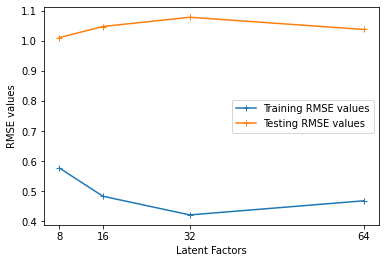

In [40]:

plt.plot(e_dim,rmse_train_values,label='Training RMSE values',linewidth=1.5,marker='+')
plt.plot(e_dim,rmse_test_values,label='Testing RMSE values',linewidth=1.5,marker='+')
plt.xlabel('Latent Factors')
plt.ylabel('RMSE values')
plt.xticks(e_dim)
plt.legend()
plt.savefig('Task 5 - Tuning.png')
plt.show


## Evaluating Other Models



In [41]:
class StaticModel:
  
  def __init__(self, staticscores):
    self.numitems = len(staticscores)
    self.staticscores = staticscores
  
  #uids are the user(s) we are requesting recommendations for;
  #returns an array of scores, one for each item
  #the array is duplicated for each user requested
  def predict(self, uids, iids=None):
    #this model returns all zeros, regardless of userid
    
    #we respond to one or more uids
    uids = [uids] if isinstance(uids, int) else uids

    #if iids is specificed, we filter predicts for those userids
    iids = np.arange(self.numitems) if iids is None else iids
    return [self.staticscores[iids] for u in uids]

In [42]:
mydummymodel = StaticModel(np.zeros(num_items))

print("Asking for 2 users, one item: " + str(mydummymodel.predict([0,1],0)))
print("Asking for one item: " + str(mydummymodel.predict(0,0)))
print("Asking for two items: " + str(mydummymodel.predict(0,[0,1])))
print("RMSE of our dummy model: %f" % rmse_score(mydummymodel, test))

Asking for 2 users, one item: [0.0, 0.0]
Asking for one item: [0.0]
Asking for two items: [array([0., 0.])]
RMSE of our dummy model: 3.642758


## Popularity-based Recommenders



In [43]:
#solution here
#task a - Normalise ratings for each item

items_df=ratings_df[["movieId","rating"]].groupby(["movieId"])
total_items=items_df.count() #denominator
#[(a-min)/(max-min)]*5 -> Normalisation to 5 
total_items['rating'] = (total_items['rating'] -  total_items['rating'].min())/(total_items['rating'].max()-total_items['rating'].min())*5
total_items['rating'].values

array([3.26219512, 1.99695122, 0.19817073, ..., 0.0152439 , 0.0304878 ,
       0.        ])

In [44]:
mydummymodel = StaticModel(total_items['rating'].values)

print("Asking for 2 users, one item: " + str(mydummymodel.predict([0,1],0)))
print("Asking for one item: " + str(mydummymodel.predict(0,0)))
print("Asking for two items: " + str(mydummymodel.predict(0,[0,1])))
print("RMSE of our dummy model: %f" % rmse_score(mydummymodel, test))

Asking for 2 users, one item: [3.2621951219512195, 3.2621951219512195]
Asking for one item: [3.2621951219512195]
Asking for two items: [array([3.26219512, 1.99695122])]
RMSE of our dummy model: 3.514168


In [45]:
#task b- Normalise the 5 star scores
five_star_items = items_df.rating.agg(lambda x: x[x==5.0].value_counts() if len(x[x==5.0].value_counts()==0) else 0)

five_star_items=np.array(five_star_items.values)
#same normalisation like before
five_star_items=(five_star_items - five_star_items.min())/(five_star_items.max() - five_star_items.min()) * 5

In [46]:
five_star_items

array([1.53594771, 0.32679739, 0.        , ..., 0.        , 0.        ,
       0.        ])

In [47]:
#dummy model with five_star_items
mydummymodel = StaticModel(five_star_items)

print("Asking for 2 users, one item: " + str(mydummymodel.predict([0,1],0)))
print("Asking for one item: " + str(mydummymodel.predict(0,0)))
print("Asking for two items: " + str(mydummymodel.predict(0,[0,1])))
print("RMSE of our dummy model: %f" % rmse_score(mydummymodel, test))

Asking for 2 users, one item: [1.5359477124183007, 1.5359477124183007]
Asking for one item: [1.5359477124183007]
Asking for two items: [array([1.53594771, 0.32679739])]
RMSE of our dummy model: 3.590646


In [48]:
#task c- average rating value - no normalisation
average_rating= items_df.agg(average_rating=('rating',np.mean))
average_rating['average_rating'].values

array([3.92093023, 3.49621212, 2.78571429, ..., 3.25      , 3.16666667,
       3.        ])

In [49]:
#dummy model for average rating 
mydummymodel = StaticModel(average_rating['average_rating'].values)

print("Asking for 2 users, one item: " + str(mydummymodel.predict([0,1],0)))
print("Asking for one item: " + str(mydummymodel.predict(0,0)))
print("Asking for two items: " + str(mydummymodel.predict(0,[0,1])))
print("RMSE of our dummy model: %f" % rmse_score(mydummymodel, test))

Asking for 2 users, one item: [3.9209302325581397, 3.9209302325581397]
Asking for one item: [3.9209302325581397]
Asking for two items: [array([3.92093023, 3.49621212])]
RMSE of our dummy model: 1.418723


# Implicit Recommendation



In [50]:
!rm -rf lastfm-dataset-1K.tar.gz
!curl -o "lastfm-dataset-1K.tar.gz" "http://www.dcs.gla.ac.uk/~craigm/recsysH/lastfm-dataset-1K.tar.gz"
#backup location
#!curl -o "lastfm-dataset-1K.tar.gz" http://macavaney.us/misc/lastfm-dataset-1K.tar.gz
!tar -zxvf lastfm-dataset-1K.tar.gz
!ls -lh lastfm-dataset-1K/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  641M  100  641M    0     0  10.4M      0  0:01:01  0:01:01 --:--:-- 11.1M
lastfm-dataset-1K/
lastfm-dataset-1K/userid-profile.tsv
lastfm-dataset-1K/README.txt
lastfm-dataset-1K/userid-timestamp-artid-artname-traid-traname.tsv
total 2.4G
-rw-r--r-- 1 1002 1002 2.2K Mar 23  2010 README.txt
-rw-r--r-- 1 1002 1002  37K Dec 30  2009 userid-profile.tsv
-rw-r--r-- 1 1002 1002 2.4G Mar  4  2010 userid-timestamp-artid-artname-traid-traname.tsv


In [51]:
listens_df = pd.read_csv("lastfm-dataset-1K/userid-timestamp-artid-artname-traid-traname.tsv",  names=['user', 'timestamp', 'artistid', 'artist', 'trackid', 'trackname'], header=None, sep='\t')

#Some tracks dont seem to have artists or track names, so lets drop them for simplicity.
listens_df = listens_df[listens_df.artist.notnull()]
listens_df = listens_df[listens_df.trackname.notnull()]

#the dataframe is VERY big (19M interactions), so lets just work with a small sample of it (this will mean that effectiveness will be lower, but learning will be MUCH faster).
listens_df = listens_df.sample(n=200000, random_state=np.random.RandomState(SEED))

In [52]:
listens_df.head()

,user,timestamp,artistid,artist,trackid,trackname
11087179,user_000593,2007-05-14T18:49:03Z,ad996aef-cc1c-42ac-af5c-619c370f4b8a,"Emerson, Lake & Palmer",NaN,Three Fates (Clotho/Lachesis/Atropos)
1911790,user_000093,2008-08-18T22:04:59Z,8c538f11-c141-4588-8ecb-931083524186,Bloc Party,315a301e-e764-4adf-91c6-e90a22320106,Positive Tension
11099786,user_000594,2008-04-06T10:57:45Z,65f4f0c5-ef9e-490c-aee3-909e7ae6b2ab,Metallica,683c89fe-2be8-4ed2-8e58-68b2343cb8d5,Through The Never
12076983,user_000651,2008-05-10T07:14:45Z,3ca09fae-fdee-4771-bab9-244708515a98,Omarion,NaN,Ice Box [Orangefuzzz Weather Advisory Radio Mix]
2680461,user_000137,2009-03-11T23:17:22Z,af84ee9f-534a-4f7f-844b-188ba1c47e87,Los Rodríguez,76b83f07-3763-4c17-8d24-28040d85354a,Dulce Condena


In [53]:
from collections import defaultdict
from itertools import count

#we cant trust the musicbrainz ids to exist, so lets build items ids based on artist & trackname attributes
LFMiid_map = defaultdict(count().__next__)
LFMiids = np.array([LFMiid_map[artist+"/"+trackname] for artist,trackname in listens_df[["artist","trackname"]].values ], dtype=np.int32)

LFMuid_map = defaultdict(count().__next__)
LFMuids = np.array([LFMuid_map[uid] for uid in listens_df["user"].values ], dtype=np.int32)
#freeze uid_map and iid_map so no more mapping are created
LFMuid_map.default_factory = None
LFMiid_map.default_factory = None

LFMuid_rev_map = {v: k for k, v in LFMuid_map.items()}
LFMiid_rev_map = {v: k for k, v in LFMiid_map.items()}

from spotlight.interactions import Interactions
from spotlight.cross_validation import random_train_test_split

#NB: we will set num_users and num_items here - its a good practice.
imp_dataset = Interactions(user_ids=LFMuids, item_ids=LFMiids, num_users=len(LFMuid_map), num_items=len(LFMiid_map))
#we could add the timestamps here if we were doing sequence recommendation

#what have we got.
print(imp_dataset)

<Interactions dataset (973 users x 125076 items x 200000 interactions)>


In [54]:
from spotlight.cross_validation import random_train_test_split

itrain, itest = random_train_test_split(imp_dataset, random_state=np.random.RandomState(SEED))
print(itrain)
print(itest)

<Interactions dataset (973 users x 125076 items x 160000 interactions)>
<Interactions dataset (973 users x 125076 items x 40000 interactions)>


In [55]:
from spotlight.factorization.implicit import ImplicitFactorizationModel
import time  

imodel = ImplicitFactorizationModel(n_iter=5, 
                                    embedding_dim=32, #this is Spotlight default
                                    use_cuda=False,
                                    random_state=np.random.RandomState(SEED) # ensure results are repeatable
)
current = time.time()

imodel.fit(itrain, verbose=True)
end = time.time()
diff = end - current
print("Training took %d seconds" % (diff))

Epoch 0: loss 0.9663112537384033
Epoch 1: loss 0.4953250964164734
Epoch 2: loss 0.19036926743984223
Epoch 3: loss 0.11518938970565797
Epoch 4: loss 0.08347186335921288
Training took 156 seconds


In [56]:
print(imodel.predict(0))
print(len(imodel.predict(0)))

[ -4.757586   5.261482  -9.297717 ...  -9.027796 -11.657988 -13.502052]
125076




##  Track Analysis




In [57]:
#your solution here
from scipy.stats import rankdata
def tracksForUser(user,k): 
  #k-number of tracks
  tracks=np.arange(imodel._num_items)
  user_score=imodel.predict(user)
  ranking=rankdata(user_score,method='ordinal')#ranking the user_scores
  #sort the ranks to the tracks
  sorted_tracks= [x for i,x in sorted(zip(ranking,tracks),reverse=True)]
  top_k_tracks=sorted_tracks[0:k] #gives top k sorted tracks
  
  recommended_list=[]
  for i in top_k_tracks:
    recommended_list.append(LFMiid_rev_map.get(i))

  return recommended_list


In [58]:
tracksForUser(4,10)

['Evanescence/Sweet Sacrifice',
 'Mgmt/Kids',
 'The Killers/Bones',
 'Nelly Furtado/Say It Right',
 'Kings Of Leon/Use Somebody',
 'Amy Winehouse/Back To Black',
 'Red Hot Chili Peppers/The Zephyr Song',
 'Radiohead/Fake Plastic Trees',
 'Incubus/Drive',
 'Him/The Funeral Of Hearts']

## Artist Analysis



In [59]:
#your solution here
listens_df.head()

,user,timestamp,artistid,artist,trackid,trackname
11087179,user_000593,2007-05-14T18:49:03Z,ad996aef-cc1c-42ac-af5c-619c370f4b8a,"Emerson, Lake & Palmer",NaN,Three Fates (Clotho/Lachesis/Atropos)
1911790,user_000093,2008-08-18T22:04:59Z,8c538f11-c141-4588-8ecb-931083524186,Bloc Party,315a301e-e764-4adf-91c6-e90a22320106,Positive Tension
11099786,user_000594,2008-04-06T10:57:45Z,65f4f0c5-ef9e-490c-aee3-909e7ae6b2ab,Metallica,683c89fe-2be8-4ed2-8e58-68b2343cb8d5,Through The Never
12076983,user_000651,2008-05-10T07:14:45Z,3ca09fae-fdee-4771-bab9-244708515a98,Omarion,NaN,Ice Box [Orangefuzzz Weather Advisory Radio Mix]
2680461,user_000137,2009-03-11T23:17:22Z,af84ee9f-534a-4f7f-844b-188ba1c47e87,Los Rodríguez,76b83f07-3763-4c17-8d24-28040d85354a,Dulce Condena


In [60]:
#your solution here
artist_df = pd.DataFrame(listens_df[['user','artist']].groupby(['user','artist']).artist.agg('count'))
artist_df.columns =['Frequency']
artist_df.sort_values(by=['Frequency'], ascending = False).loc[LFMuid_rev_map.get(4),:] #u4

,Frequency
artist,
Soda Stereo,39
Gustavo Cerati,36
Radiohead,31
Lucybell,27
Silvio Rodríguez,16
...,...
Scissor Sisters,1
Sanalejo,1
Saiko,1


## Evaluating an implicit recommender




In [61]:
from spotlight.evaluation import mrr_score

#evaluate on this dataset takes approx 1 minute
!date
print(mrr_score(imodel, itest).mean())
!date
print(mrr_score(imodel, itest,  train=itrain).mean())
!date


Mon Oct 11 14:15:52 UTC 2021
0.03720125940064275
Mon Oct 11 14:16:27 UTC 2021
0.008104536778740273
Mon Oct 11 14:17:03 UTC 2021


## Task 9. Listens and Recommendations




In [62]:
#solution goes here.
rr_user = mrr_score(imodel, itest)
rr_1 = np.where(rr_user == 1)[0][0] #lowest uid wiht RR =1 
user_1 = itrain.user_ids[rr_1] #corresponding userId

In [63]:
user_1 #???

650

In [64]:
#no. of listens
song_user_1=itrain.item_ids[itrain.user_ids==user_1]
song_user_1.size #109 listens???

109

In [65]:
rr_min=np.where(rr_user == rr_user.min())[0][0]
user_min=itrain.user_ids[rr_min]
user_min #what is this??? #check later

162

In [66]:
song_user_min=itrain.item_ids[itrain.user_ids==user_min]
song_user_min.size #387 listens??

387

In [67]:
#solution goes here

n_songs=[]
userids =[] 
for user in range(imodel._num_users):
  n_songs.append(len(itrain.item_ids[itrain.user_ids==user]))
  userids.append(LFMuid_rev_map.get(user))

users_df= pd.DataFrame(userids,columns=['user'])
users_df['n_songs'] = n_songs

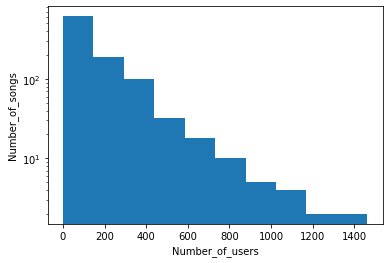

In [68]:
import matplotlib.pyplot as plt

plt.hist(np.array(n_songs),log=True)#log=True
plt.xlabel("Number_of_users")
plt.ylabel("Number_of_songs")
plt.savefig('Task 9 - Distribution.png')
plt.show()

In [69]:
#normal user >20 listen
n_songs=np.array(n_songs)
normal_users=np.where(n_songs>=20)
#rest cold start user
cold_start_users=np.where(n_songs<20)

In [70]:
len(normal_users[0]),len(cold_start_users[0])

(811, 162)

In [71]:
#calculating mrr_score
mrr_score=mrr_score(imodel,itest)

In [72]:
#for normla users
normal_mrr=np.take(mrr_score,normal_users[0]).mean()
normal_mrr

0.04414792633041709

In [73]:
#for cold start
cold_mrr=np.take(mrr_score,cold_start_users[0]).mean()
cold_mrr #for mrr the higheer the better #normal user is better to recommend than cold start

0.0024250440917107582

##  - BPR



In [74]:
#solution goes here
#implict factorisation model with BPR
#default setting with loss='bpr'
bpr=ImplicitFactorizationModel(n_iter=5,embedding_dim=32,use_cuda=False,random_state=np.random.RandomState(SEED),loss='bpr')
#fit the model with training data
a=time.time()
bpr.fit(itrain,verbose=True)
b=time.time()
total_time=b-a
total_time #pointwist time = 158 seconds #pointwise loss = 0.083

Epoch 0: loss 0.4740972354888916
Epoch 1: loss 0.14683696522712708
Epoch 2: loss 0.024808155296742917
Epoch 3: loss 0.014375447143614292
Epoch 4: loss 0.01111387666836381


156.71679019927979

In [77]:
!date
print(mrr_score(bpr, itest).mean())

Mon Oct 11 14:26:08 UTC 2021


TypeError: ignored